# Lab 2 - Simple CNN

In [1]:
import torch, torchvision
import matplotlib.pyplot as plt

In [2]:
mnist_ds_train = torchvision.datasets.MNIST(
    "./lab2_data/",
    train=True,
    download=True,
    transform=torchvision.transforms.ToTensor(),
)

fashion_mnist_ds_train = torchvision.datasets.FashionMNIST(
    "./lab2_data/",
    train=True,
    download=True,
    transform=torchvision.transforms.ToTensor(),
)

mnist_ds_test = torchvision.datasets.MNIST(
    "./lab2_data/",
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor(),
)

fashion_mnist_ds_test = torchvision.datasets.FashionMNIST(
    "./lab2_data/",
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor(),
)

In [3]:
from torch.utils.data import Dataset, DataLoader


class LeftOrRightDataset(Dataset):
    def __init__(self, mnist_ds: Dataset, fashion_mnist_ds: Dataset) -> None:
        assert len(mnist_ds) == len(fashion_mnist_ds)

        self.images = []

        mnist_loader = DataLoader(mnist_ds, batch_size=1, shuffle=True, num_workers=0)
        fashion_left_loader = DataLoader(
            fashion_mnist_ds, batch_size=1, shuffle=True, num_workers=0
        )

        fashion_right_loader = DataLoader(
            fashion_mnist_ds, batch_size=1, shuffle=True, num_workers=0
        )

        for (mnist, left_fashion, right_fashion) in zip(
            mnist_loader, fashion_left_loader, fashion_right_loader
        ):
            new_image = torch.cat((left_fashion[0].squeeze(0), mnist[0].squeeze(0), right_fashion[0].squeeze(0)), 2)
            new_label = left_fashion[1] if mnist[1] % 2 == 0 else right_fashion[1] 
            self.images.append((new_image, new_label))

    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img, label = self.images[idx]
        return img, label

In [4]:
ds_train = LeftOrRightDataset(mnist_ds_train, fashion_mnist_ds_train)
ds_test = LeftOrRightDataset(mnist_ds_test, fashion_mnist_ds_test)

In [5]:
len(ds_train), len(ds_test)

(60000, 10000)

Fashion MNIST labels:
* 0 T-shirt/top
* 1 Trouser
* 2 Pullover
* 3 Dress
* 4 Coat
* 5 Sandal
* 6 Shirt
* 7 Sneaker
* 8 Bag
* 9 Ankle boot

tensor([6])


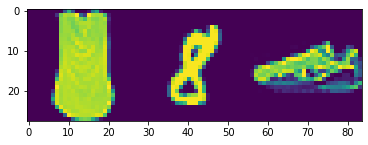

In [6]:
plt.imshow(ds_train[42][0].permute(1,2,0).numpy())
print(ds_train[42][1])

tensor([3])


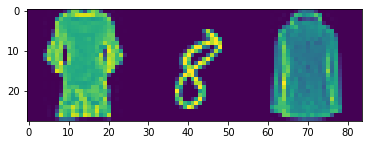

In [7]:
plt.imshow(ds_train[2137][0].permute(1,2,0).numpy())
print(ds_train[2137][1])

In [8]:
import torch.nn as nn
import torch.nn.functional as F

class LeftOrRightClassifier(nn.Module):
    def __init__(self):
        super(LeftOrRightClassifier, self).__init__()

        self.net = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(1920, 32),
            nn.ReLU(),
            nn.Linear(32, 10),
        )

    def forward(self, x):
        return self.net(x)

In [9]:
model = LeftOrRightClassifier().to("cuda")
model(ds_train[42][0].unsqueeze(0).to("cuda")).shape

torch.Size([1, 10])

In [10]:
import torch.optim as optim
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=0.001)

In [11]:
EPOCHS = 15
BATCH_SIZE = 256

train_dataloader = DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=True)

for i in range(EPOCHS):
    train_loss = 0.0
    for data, labels in train_dataloader:
        data, labels = data.to("cuda"), labels.to("cuda").squeeze(1)
        optimizer.zero_grad()

        output = model(data)
        loss = loss_function(output, labels)
        loss.backward()

        optimizer.step()

        train_loss += loss.item()
    print(
        f"Epoch: {i+1} / {EPOCHS} \t\t\t Training Loss:{train_loss/len(train_dataloader)}"
    )

Epoch: 1 / 15 			 Training Loss:1.632214711574798
Epoch: 2 / 15 			 Training Loss:1.245061680357507
Epoch: 3 / 15 			 Training Loss:0.9721017449460131
Epoch: 4 / 15 			 Training Loss:0.8041727461713426
Epoch: 5 / 15 			 Training Loss:0.6986042291560072
Epoch: 6 / 15 			 Training Loss:0.6367295431329849
Epoch: 7 / 15 			 Training Loss:0.5915303292426657
Epoch: 8 / 15 			 Training Loss:0.5560219240949509
Epoch: 9 / 15 			 Training Loss:0.524720121190903
Epoch: 10 / 15 			 Training Loss:0.5064370012029689
Epoch: 11 / 15 			 Training Loss:0.48639035719506285
Epoch: 12 / 15 			 Training Loss:0.46986726002490264
Epoch: 13 / 15 			 Training Loss:0.44903675444582675
Epoch: 14 / 15 			 Training Loss:0.43670957126515975
Epoch: 15 / 15 			 Training Loss:0.42812409692622244


tensor([[2.7582e-03, 1.5149e-03, 1.8997e-03, 6.5451e-02, 7.7429e-03, 9.1902e-02,
         1.8530e-02, 8.6175e+01, 7.6604e-03, 1.3628e+01]], device='cuda:0')
tensor([7])


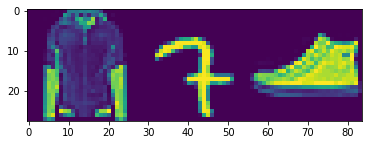

In [12]:
plt.imshow(ds_test[420][0].permute(1,2,0).numpy())
with torch.inference_mode():
    print(F.softmax(model(ds_test[420][0].unsqueeze(0).to("cuda")), 1) * 100)
    print(ds_test[420][1]) 

tensor([[1.6927e-03, 2.5039e-01, 3.0821e-01, 7.9460e-02, 5.8386e-01, 9.4560e+01,
         1.6592e-02, 3.7384e+00, 4.7109e-02, 4.1403e-01]], device='cuda:0')
tensor([5])


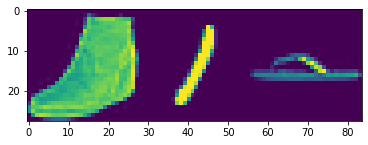

In [15]:
plt.imshow(ds_test[256][0].permute(1,2,0).numpy())
with torch.inference_mode():
    print(F.softmax(model(ds_test[256][0].unsqueeze(0).to("cuda")), 1) * 100)
    print(ds_test[256][1]) 

Fashion MNIST labels:
* 0 T-shirt/top
* 1 Trouser
* 2 Pullover
* 3 Dress
* 4 Coat
* 5 Sandal
* 6 Shirt
* 7 Sneaker
* 8 Bag
* 9 Ankle boot

In [14]:
test_dataloader = DataLoader(ds_test, batch_size=256, shuffle=True)
with torch.no_grad():
    test_loss = 0.0
    TP = 0

    for data, labels in test_dataloader:
        data, labels = data.to("cuda"), labels.to("cuda").squeeze(1)
        output = model(data)
        for o, l in zip(torch.argmax(output, axis=1), labels):
            if o == l:
                TP += 1

        loss = loss_function(output, labels)
        test_loss += loss.item()
    print(f"Testing Loss:{test_loss/len(test_dataloader)}")
    print(f"Accuracy: {TP / len(test_dataloader) / BATCH_SIZE}")

Testing Loss:0.46781594660133125
Accuracy: 0.81064453125
